In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
from os.path import join as oj
import sys
sys.path.append('../src')
import numpy as np
import seaborn as sns
import torch
import matplotlib
from matplotlib import pyplot as plt
from sklearn import metrics
import sklearn.calibration
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
# plt.style.use('dark_background')
from functools import partial
import data
from skorch.callbacks import Checkpoint
from skorch import NeuralNetRegressor
from config import *
from tqdm import tqdm
import pickle as pkl
import train_reg
from math import floor
from scipy.stats import percentileofscore
from copy import deepcopy
from sklearn.metrics import confusion_matrix
import config
import models
import pandas as pd
import features
from scipy.stats import skew, pearsonr
import outcomes
import neural_networks
from sklearn.model_selection import KFold
from torch import nn, optim
from torch.nn import functional as F
import interpret
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import viz

# prepare data

In [2]:
# currently trained only on 'clath_aux+gak_a7d2_new'
# dsets = ['clath_aux+gak_new']
dsets = ['clath_aux_dynamin']
splits = ['test']
# feat_names = ['X_same_length_normalized'] # + data.select_final_feats(data.get_feature_names(df))

#feat_names = ['X_same_length_normalized'] + data.select_final_feats(data.get_feature_names(df))
              #['mean_total_displacement', 'mean_square_displacement', 'lifetime']
meta = ['cell_num', 'Y_sig_mean', 'Y_sig_mean_normalized']
dfs, feat_names = data.load_dfs_for_lstm(dsets=dsets, splits=splits, meta=meta, normalize=False)
print('type', type(dfs))
# load model
p = 1
results = pkl.load(open(config.FINAL_MODEL, 'rb'))
dnn = neural_networks.neural_net_sklearn(D_in=40, H=20, p=p-1, arch='lstm')
dnn.model.load_state_dict(results['model_state_dict'])

# load data
# df = dfs[('clath_aux+gak_a7d2', 'train')]
# df = dfs[('clath_aux+gak_new', 'test')]
df = dfs[list(dfs.keys())[0]]
X = df[feat_names[:p]]
y = df['y_consec_thresh']


# add preds
track_name = 'X_same_length_normalized'
track_name_unnormalized = 'X_same_length'
# df = dfs[('clath_aux+gak_new', 'test')]
df['preds'] = dnn.predict(df[feat_names[:1]])
df = df.sort_values(by='preds')
x = df[feat_names[:1]]
y = df['y_consec_thresh'].values
preds = dnn.predict(x)
n = df.shape[0]

# sort things
print(f'acc {np.mean((preds > 0) == y):0.3f} vs baseline {1-np.mean(y):0.2f}', )

100%|██████████| 1/1 [00:25<00:00, 25.91s/it]


type <class 'dict'>
acc 0.841 vs baseline 0.65


# calibration plot

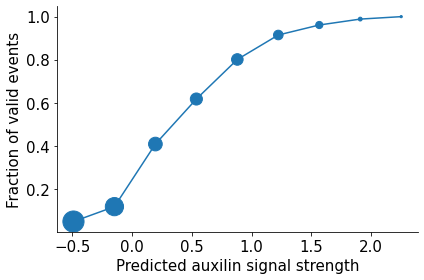

In [3]:
nbins = 10
delta = (preds.max() - preds.min()) / nbins
bins = np.linspace(preds.min(), preds.max(), nbins)
accs = (preds > 0)==y
prob_trues = []
num_pts = []
for i in range(nbins - 1):
    idxs = (preds > bins[i]) & (preds <= bins[i+1])
    num_pts.append(idxs.sum())
    prob_trues.append(y[idxs].mean())
plt.scatter(bins[:-1] + delta, prob_trues, s=np.array(num_pts)/6)    
plt.plot(bins[:-1] + delta, prob_trues, color=viz.cb)
plt.xlabel('Predicted auxilin signal strength')
plt.ylabel('Fraction of valid events')
plt.tight_layout()
viz.savefig('calibration')